# Movie Review Sentiment Analysis: From Logistic Regression to BERT

The Film Junky Union, a new community for classic movie enthusiasts, is developing a system to automatically filter and categorize user-submitted film reviews. To support this effort, this project focuses on building a machine learning model capable of detecting negative sentiment in movie reviews with a high degree of accuracy.

Using a dataset of IMDb reviews labeled for polarity (positive or negative), the objective is to train and evaluate a binary classification model that can reliably distinguish between positive and negative reviews. To ensure the model meets production standards, it must achieve an F1 score of at least 0.85 on the validation data.

This notebook will walk through the full workflow: data loading and preprocessing, exploratory analysis, feature extraction, model training and tuning, and final evaluation. The end goal is to deliver a performant sentiment classifier that can serve as the foundation for Film Junky Union’s content moderation and user engagement tools.

## Initialization

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [9]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

The data set contains over 47k movie, short, and tv show/movie reviews.  The ratings are fairly balanced and reflective of  overall sentiment with an average overall rating just shy of 6 for this media and the average for these reviews being 5.48.  Overall, the data is well-balanced with a 50:50 split.  Data for eah film contains the type of media, its title, the year it was made, how long the media is, a few genre tags, the average rating, the text of a review, the reviewer's rating, and whether or not the review is positive or negative.  The data is already split into train and test sets.

## EDA

Let's check the number of movies and reviews over years.

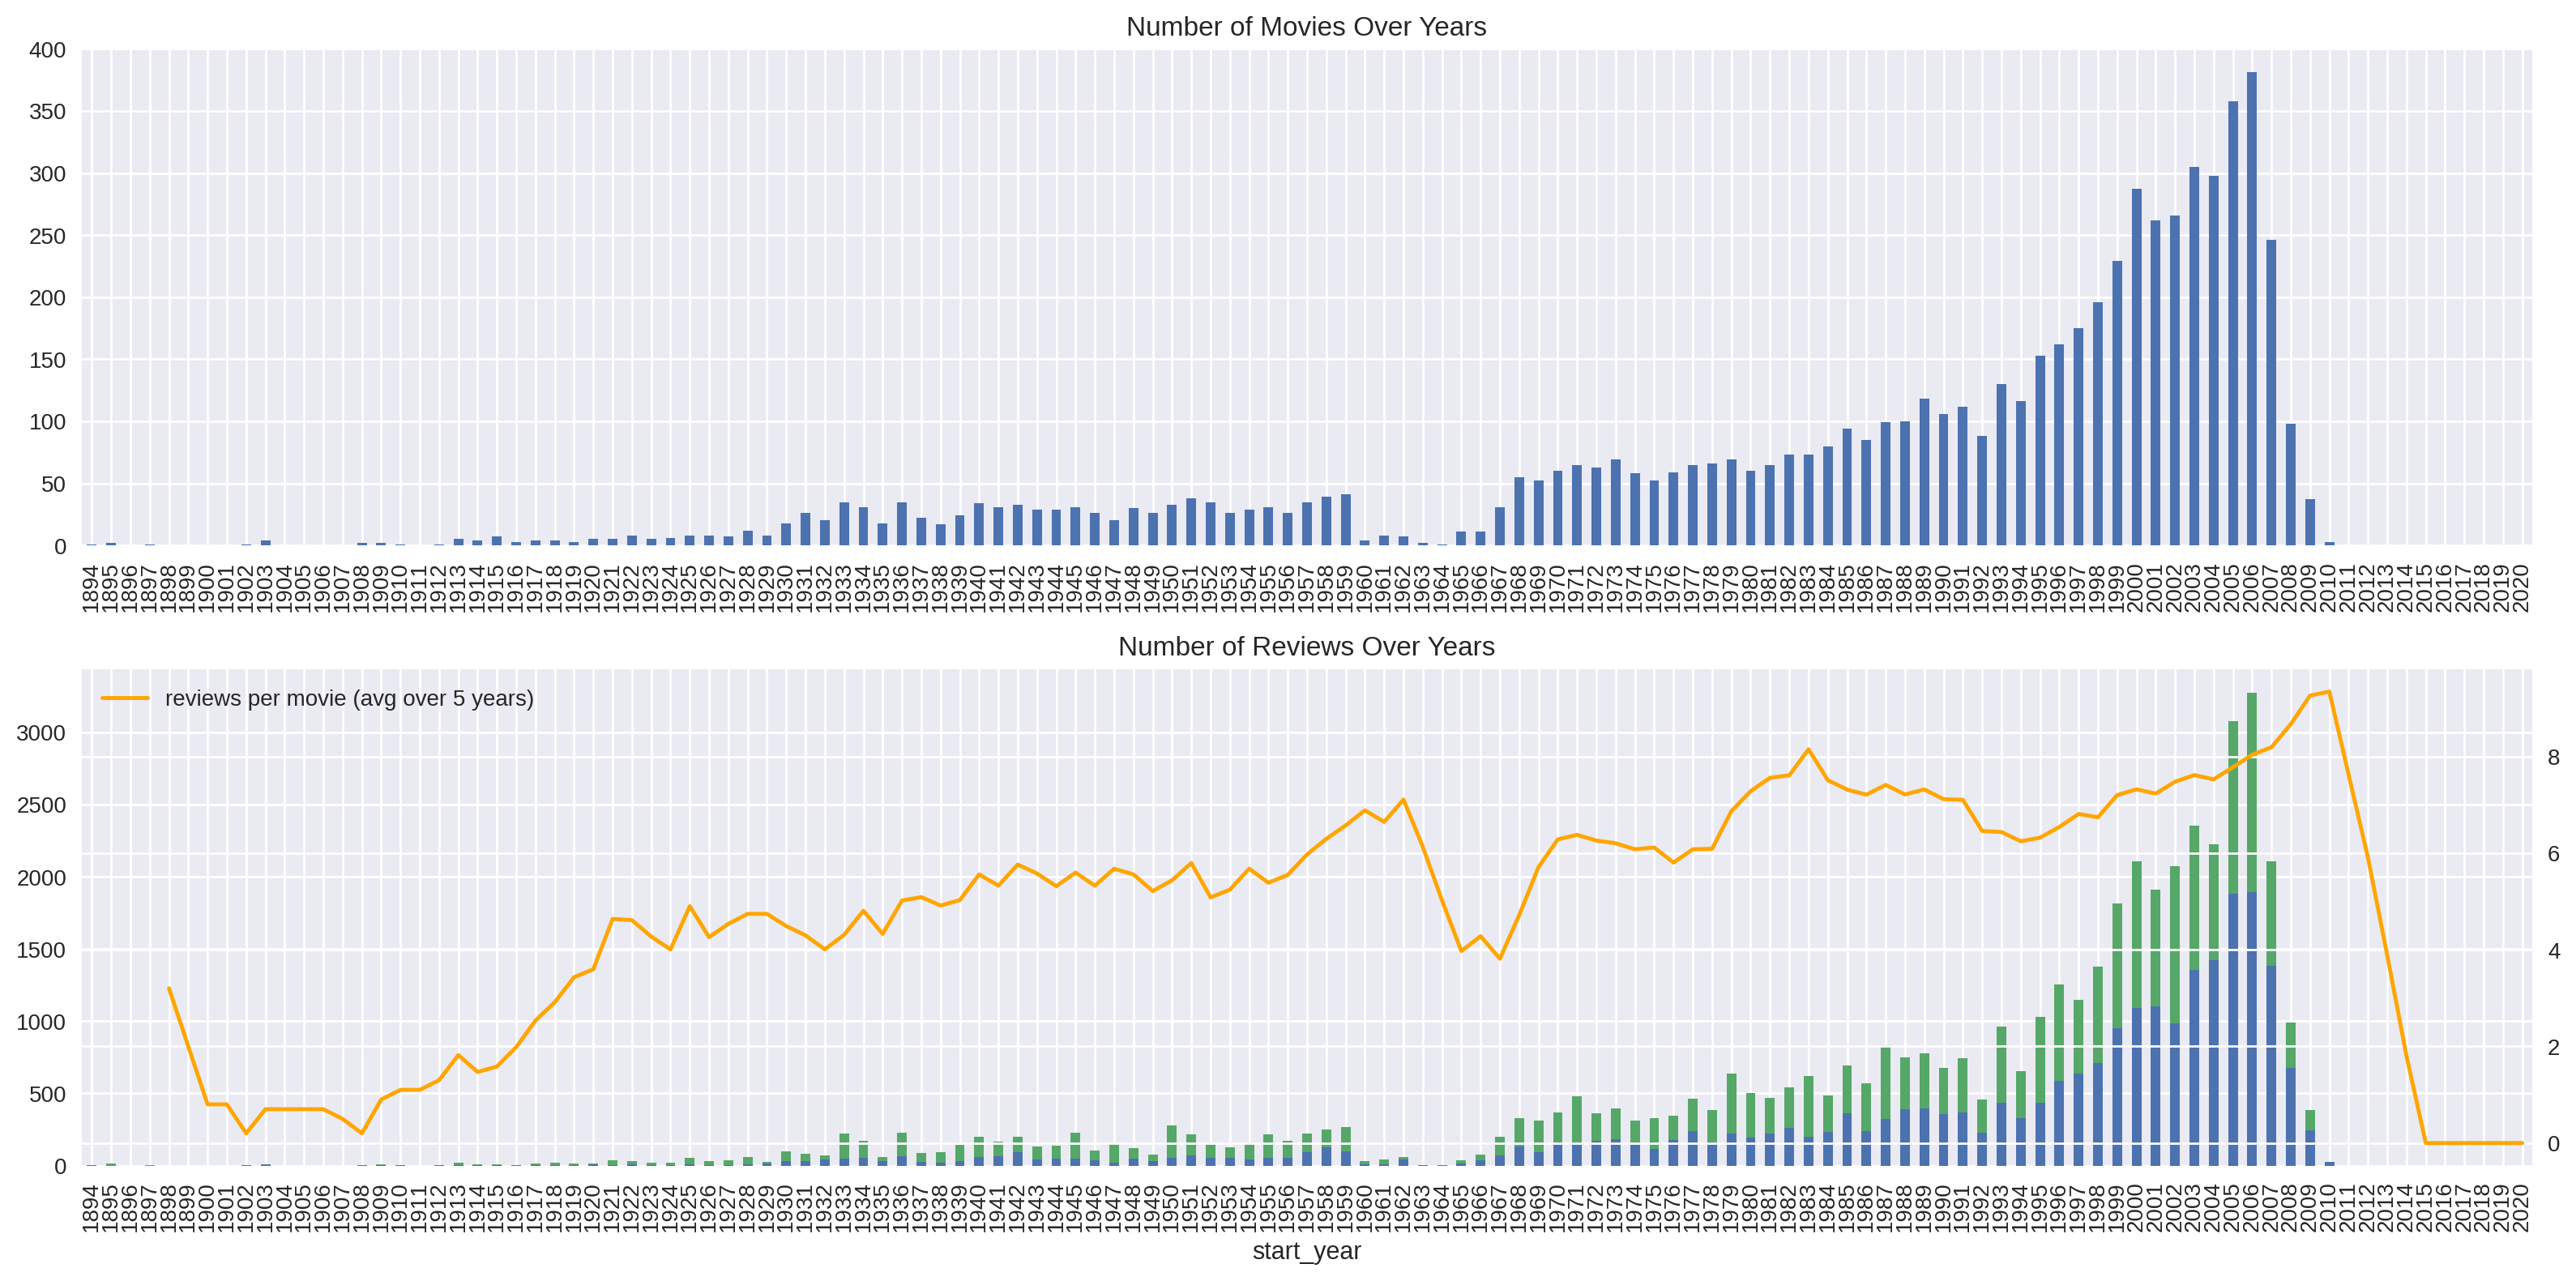

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The majority of films are from 2000-2007.  There are none made after 2010 and only a small number made before 1931.  Strangely, there is a slump in movies reviewed from the early 1960s.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

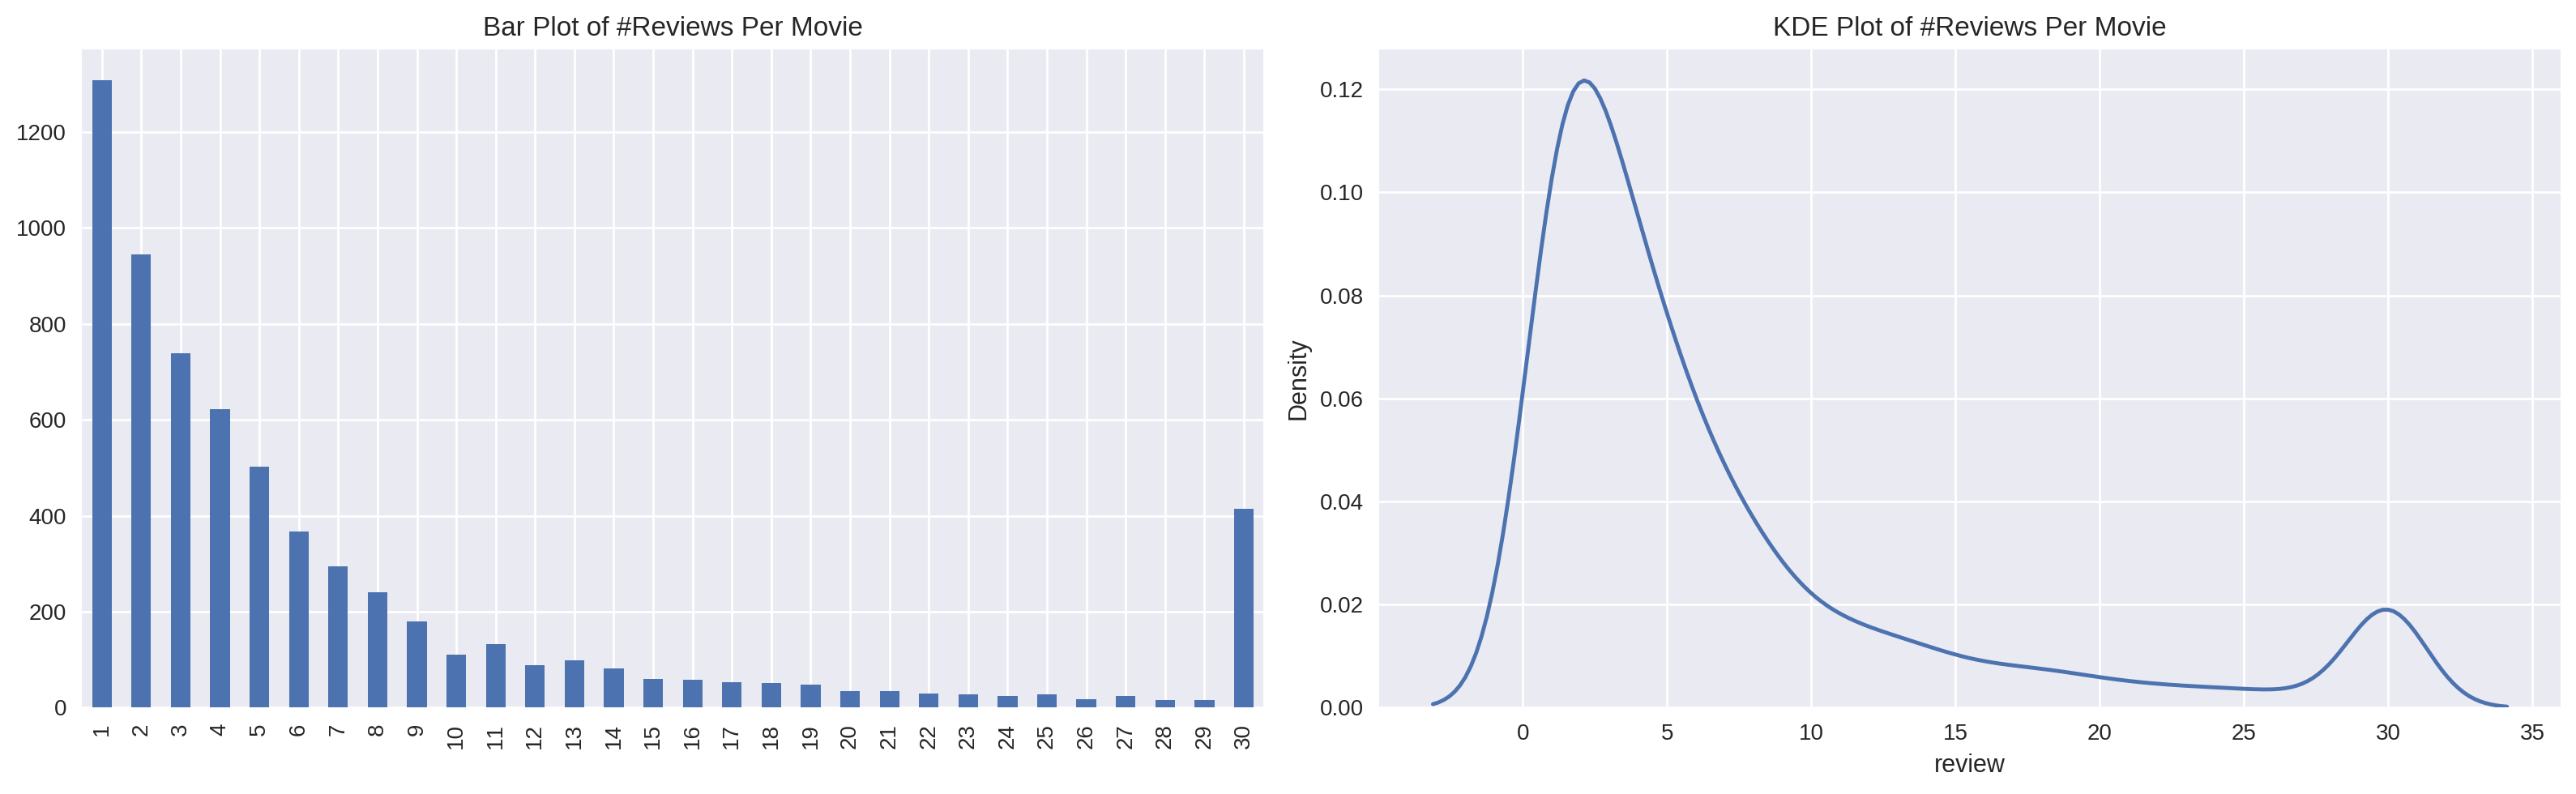

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Few films exceed around 10 reviews, though 400 have 30+ reviews.  Over 1200 of the films have only one review.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

The reviews, as noted above, are split 50:50 with a tiny bias in favor of negative reviews.

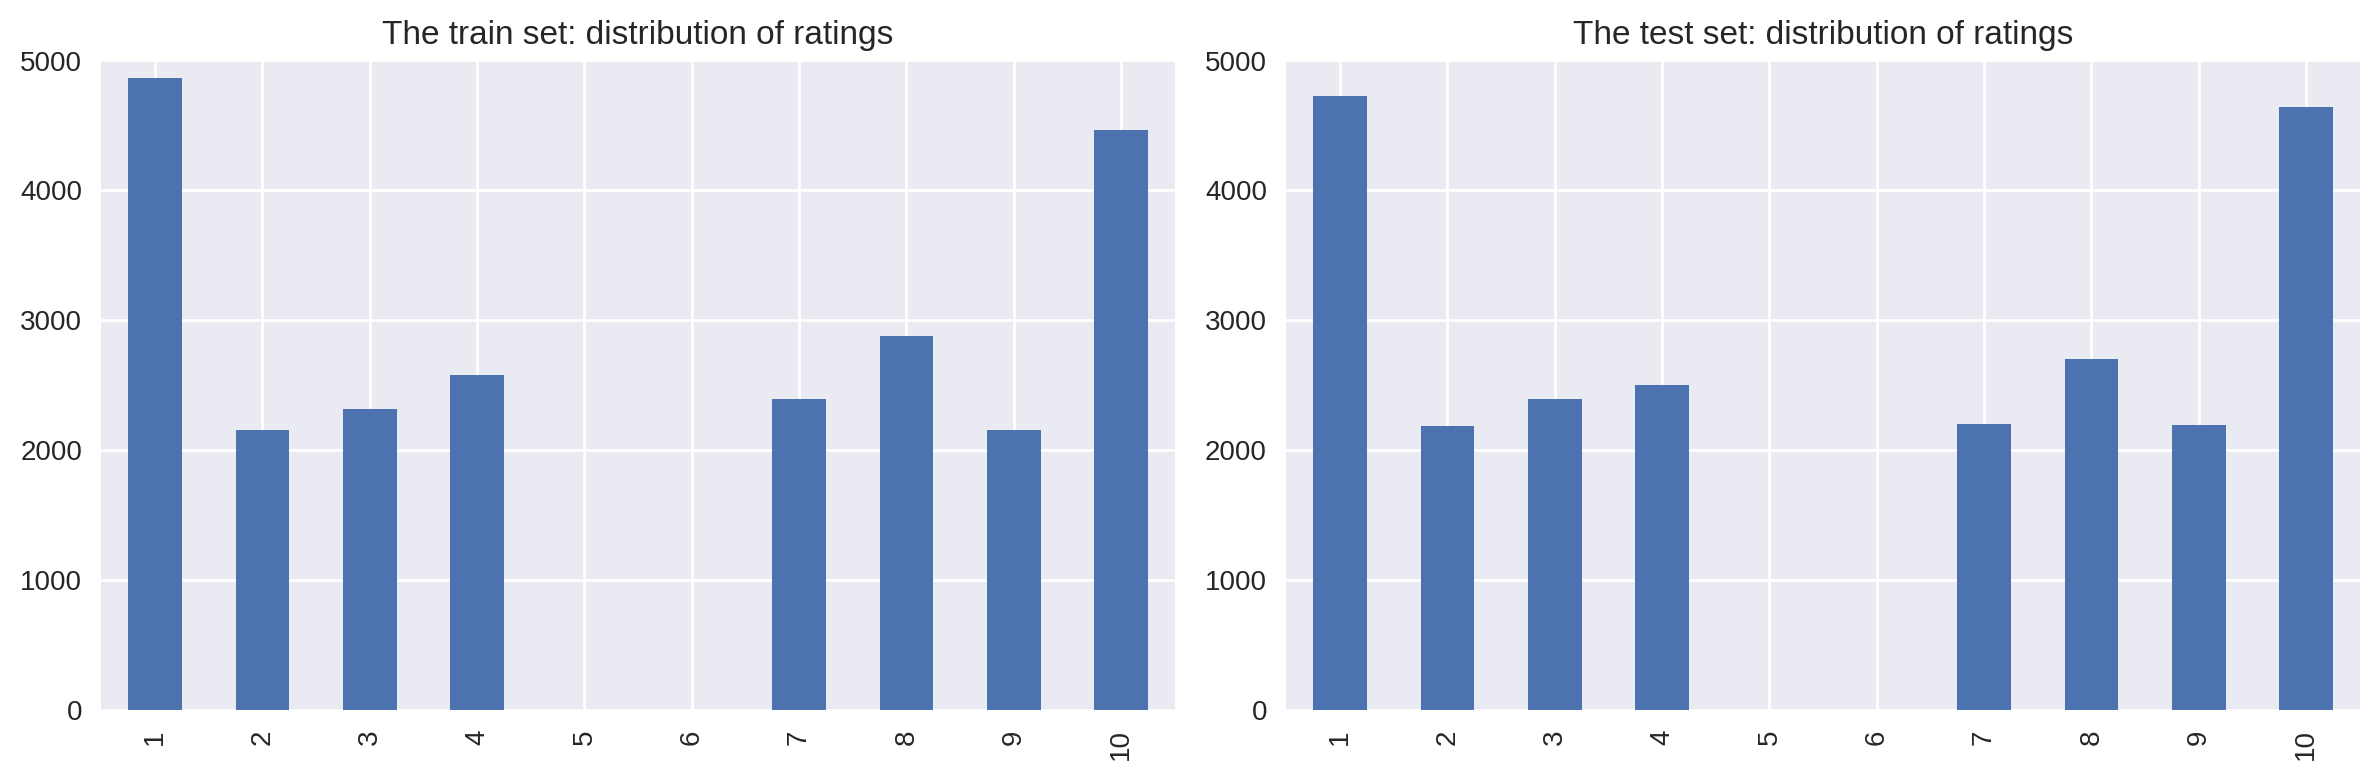

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings in the train and test sets is nearly identical.  Interestingly, seemingly no one felt neutral about the films they reviewed--there are no 5/6 reviews.  In general, reviewers had an all-or-nothing approach to reviews, with nearly double as many 1/10 reviews compared to other ratings.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


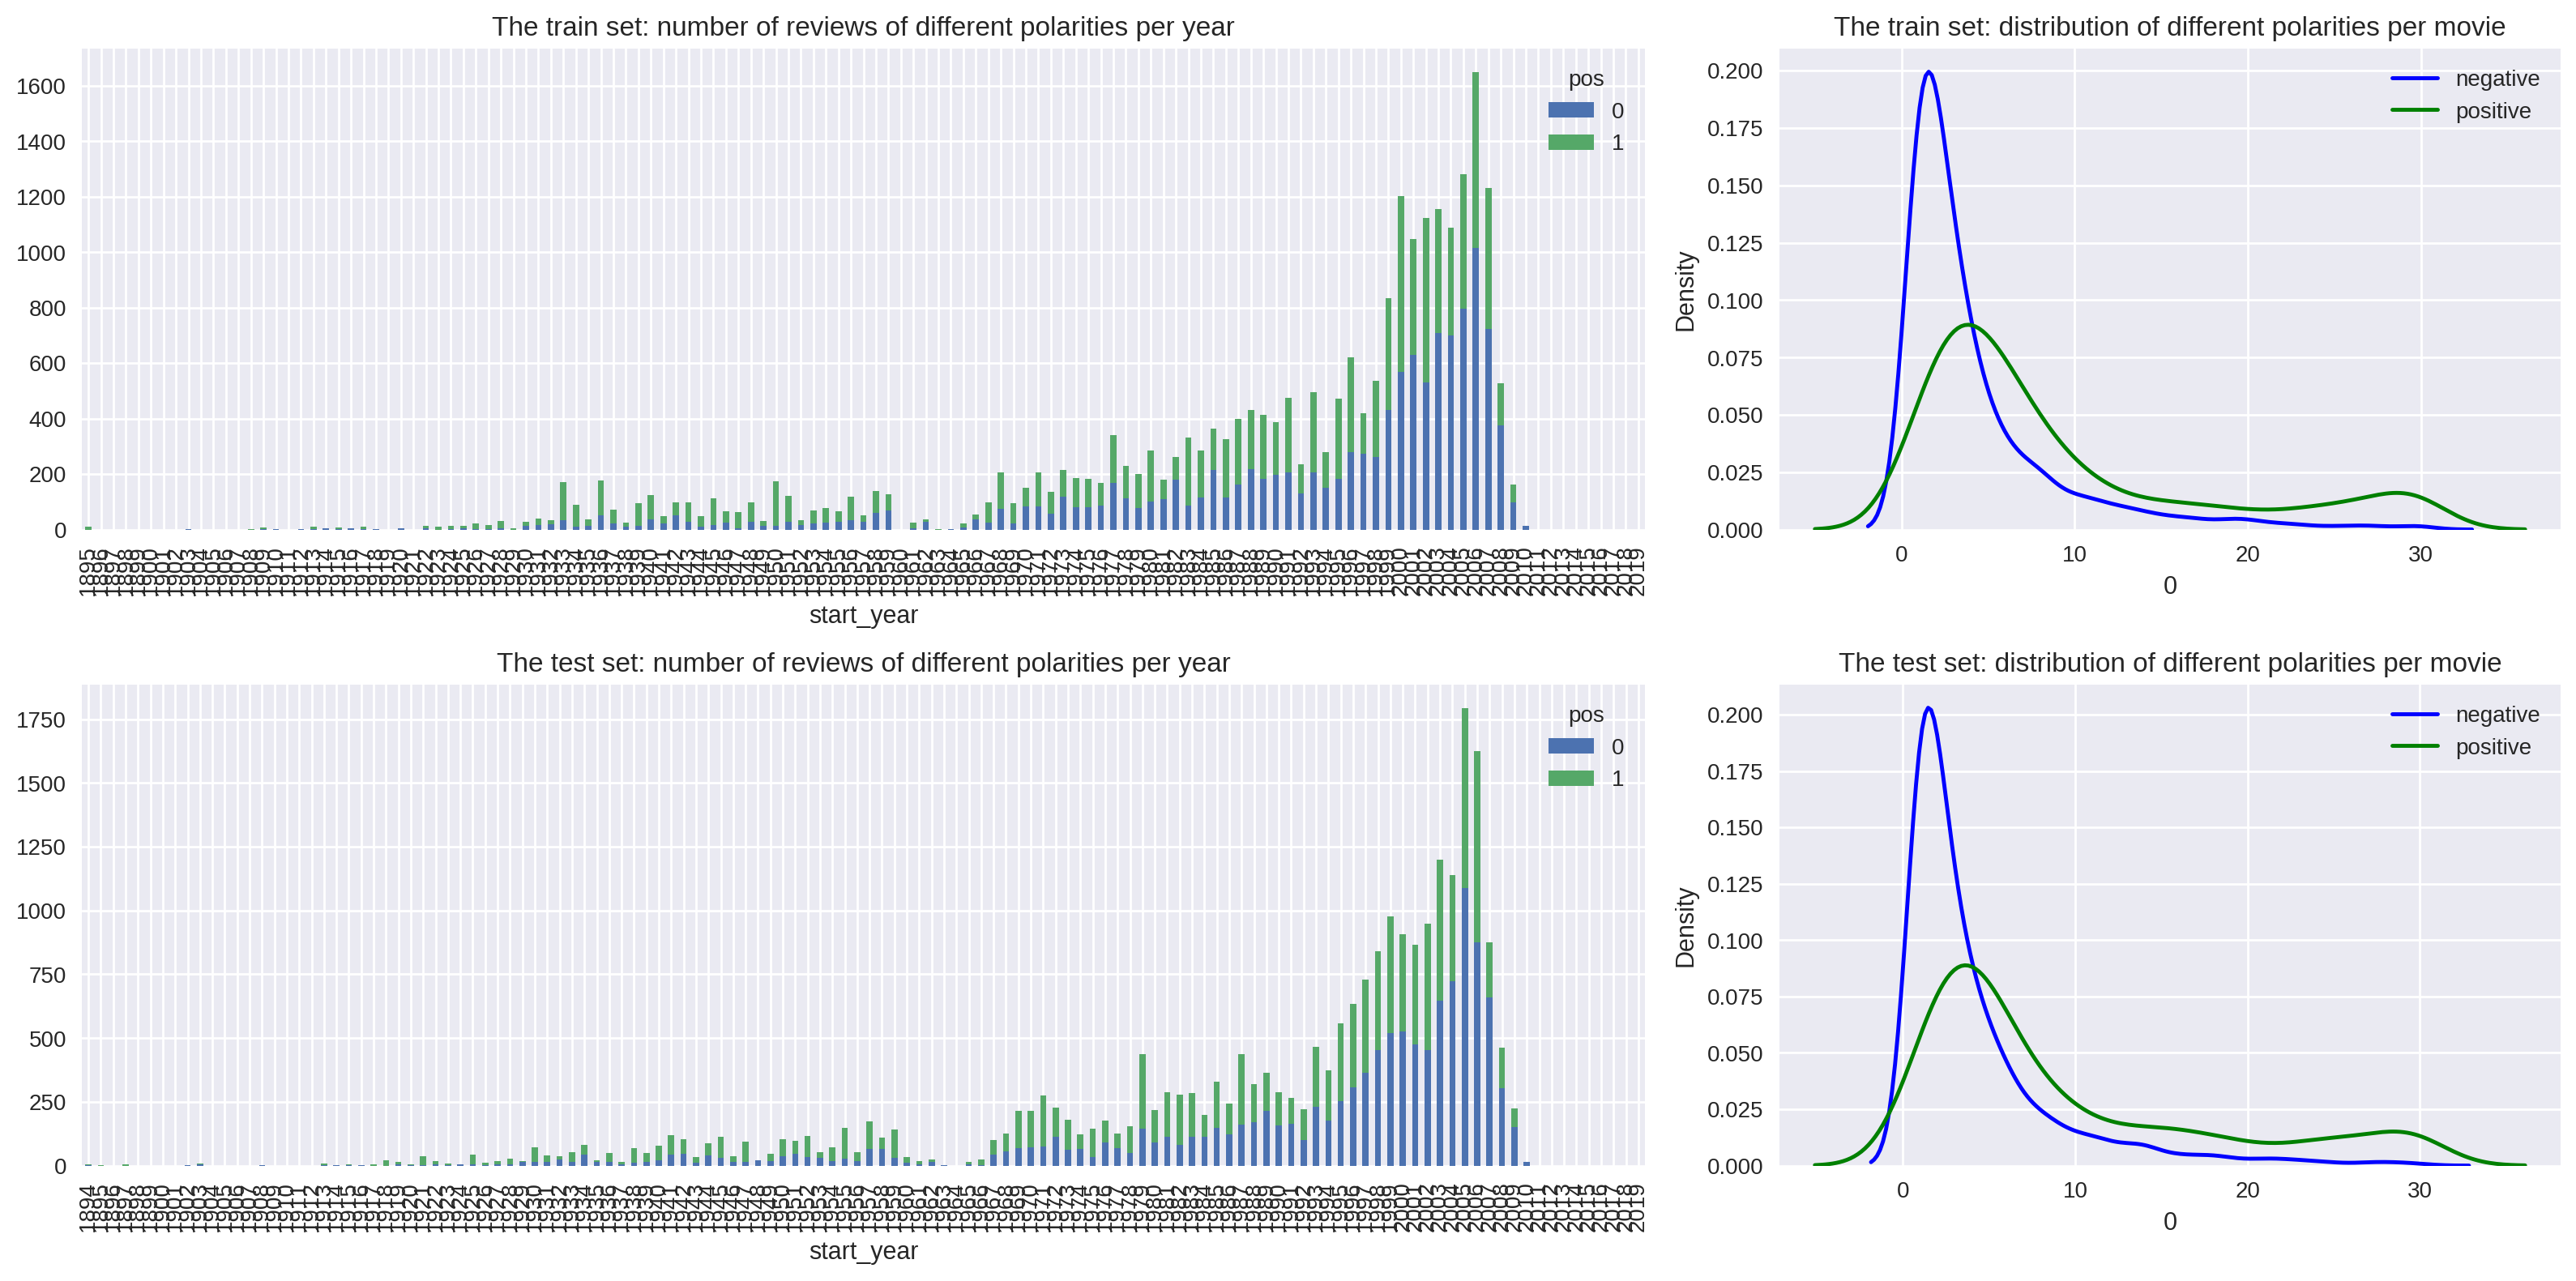

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Most films have a roughly even split of positive and negative reviews.  The train and test set mirror one another in terms of distribution, both across years and in terms of positive vs negative reviews.  Most movies have only a small number of reviews that are majority negative.  Positive reviews have a less skewed distribution.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accept texts in lowercase and without any digits, punctuations marks etc.

In [17]:
import re

In [18]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r'\d+', '', text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [19]:
df_reviews['review_norm'] = df_reviews['review'].astype(str).apply(preprocess_text)

## Encoding

In [20]:
encoded = pd.concat([
    df_reviews.reset_index(drop=True),
    df_reviews['genres'].str.get_dummies(','),
    df_reviews['title_type'].str.get_dummies()
], axis=1)

In [21]:
encoded.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx',
       'review_norm', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western', '\N', 'movie', 'short',
       'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort',
       'tvSpecial', 'video', 'videoGame'],
      dtype='object')

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = encoded.query('ds_part == "train"').copy()
df_reviews_test = encoded.query('ds_part == "test"').copy()

drop = ['tconst', 'title_type', 'primary_title', 'original_title', 'end_year', 'runtime_minutes', 'is_adult', 'genres', 'votes', 
        'review', 'sp', 'pos', 'ds_part', 'idx']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']
train_features = df_reviews_train.drop(drop, axis=1)
test_features = df_reviews_test.drop(drop, axis=1)

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 57)
(23535, 57)


In [23]:
train_features.head()

,start_year,average_rating,rating,review_norm,Action,Adult,Adventure,Animation,Biography,Comedy,...,movie,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame
0,1971,6.3,1,the pakage implies that warren beatty and gold...,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1971,6.3,1,how the hell did they get this made presenting...,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
7,1943,6.1,2,this true story of carlsons raiders is more of...,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,1943,6.1,2,should have been titled balderdash little in t...,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,1943,6.1,4,the movie gung ho the story of carlsons makin ...,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## Working with models

### Model 0 - Constant

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
model_0 = DummyClassifier(strategy='most_frequent')

In [26]:
model_0.fit(train_features, train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


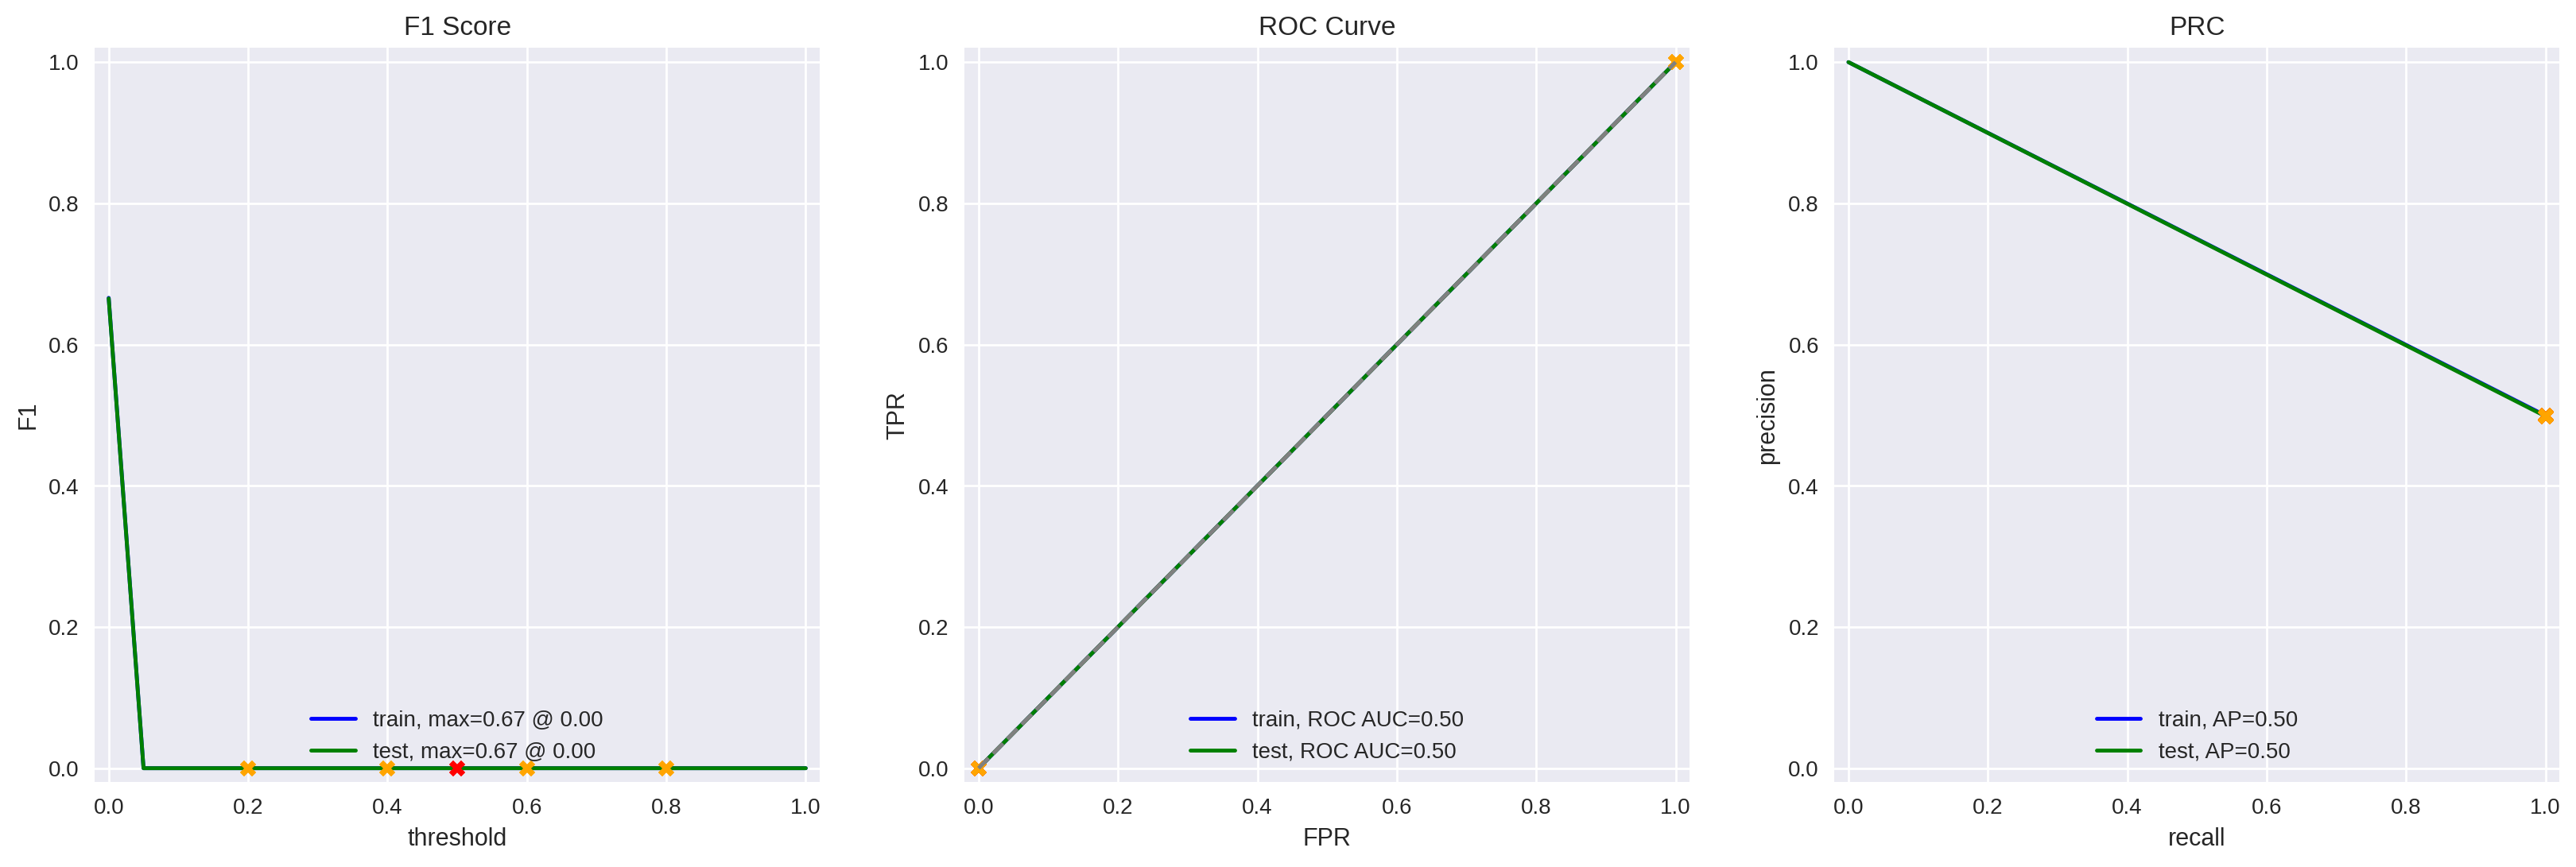

In [27]:
evaluate_model(model_0, train_features, train_target, test_features, test_target)

The dummy model works as a dummy model should.

### Model 1 - NLTK, TF-IDF and LR

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_corpus_1 = train_features['review_norm']
train_features_1 = count_tf_idf.fit_transform(train_corpus_1)
test_corpus_1 = test_features['review_norm']
test_features_1 = count_tf_idf.transform(test_corpus_1)

In [30]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


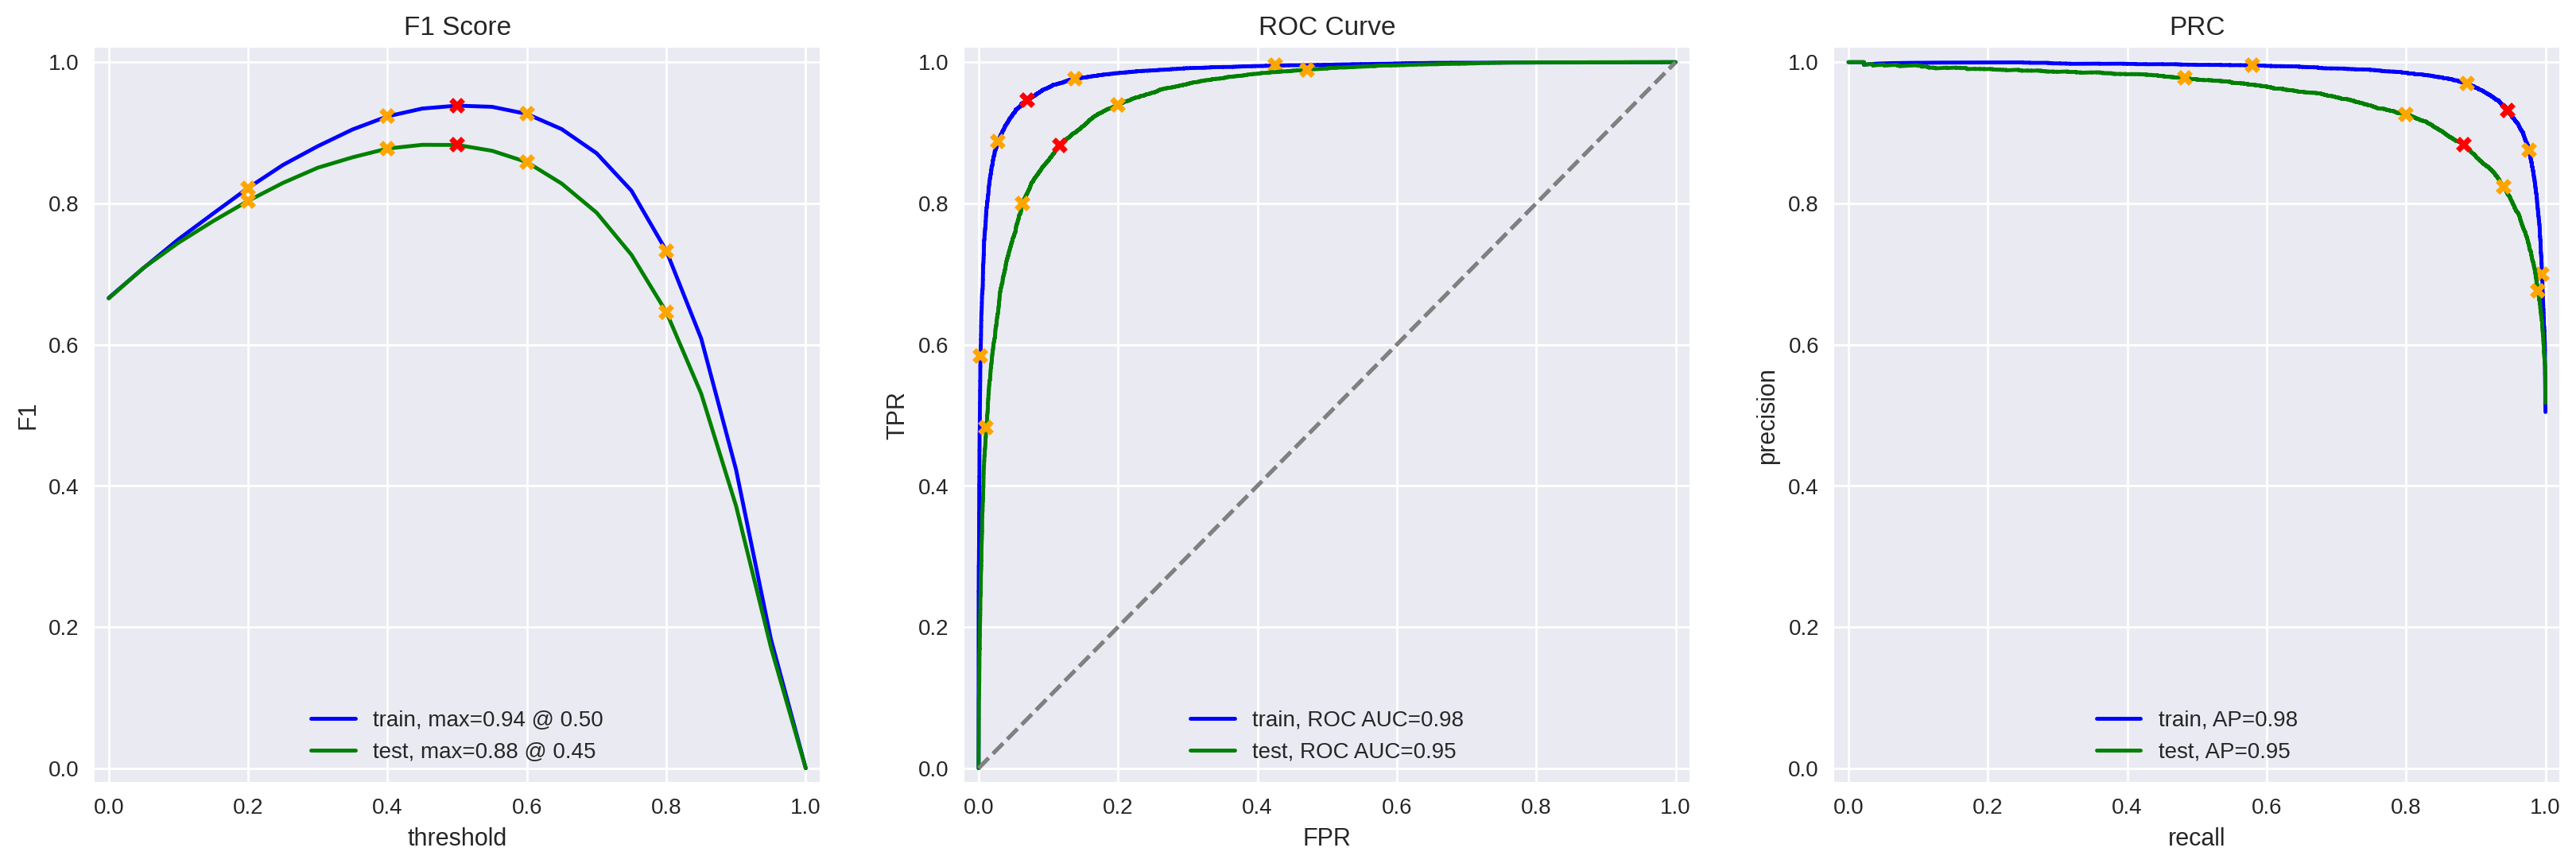

In [31]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The Linear Regression model is a great starting point.  It predicts well, with an F1 of 0.88 on the test set.  The model distinguishes between classes well, as evidenced by the high ROC-AUC and APS scores.

### Model 2 - spaCy, TF-IDF and LR

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_2(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [34]:
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)

train_corpus_2 = train_features['review_norm']
train_features_2 = train_corpus_2.apply(text_preprocessing_2)
test_corpus_2 = test_features['review_norm']
test_features_2 = test_corpus_2.apply(text_preprocessing_2)

In [35]:
train_features_2 = count_tf_idf_2.fit_transform(train_features_2)
test_features_2 = count_tf_idf_2.transform(test_features_2)

In [36]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


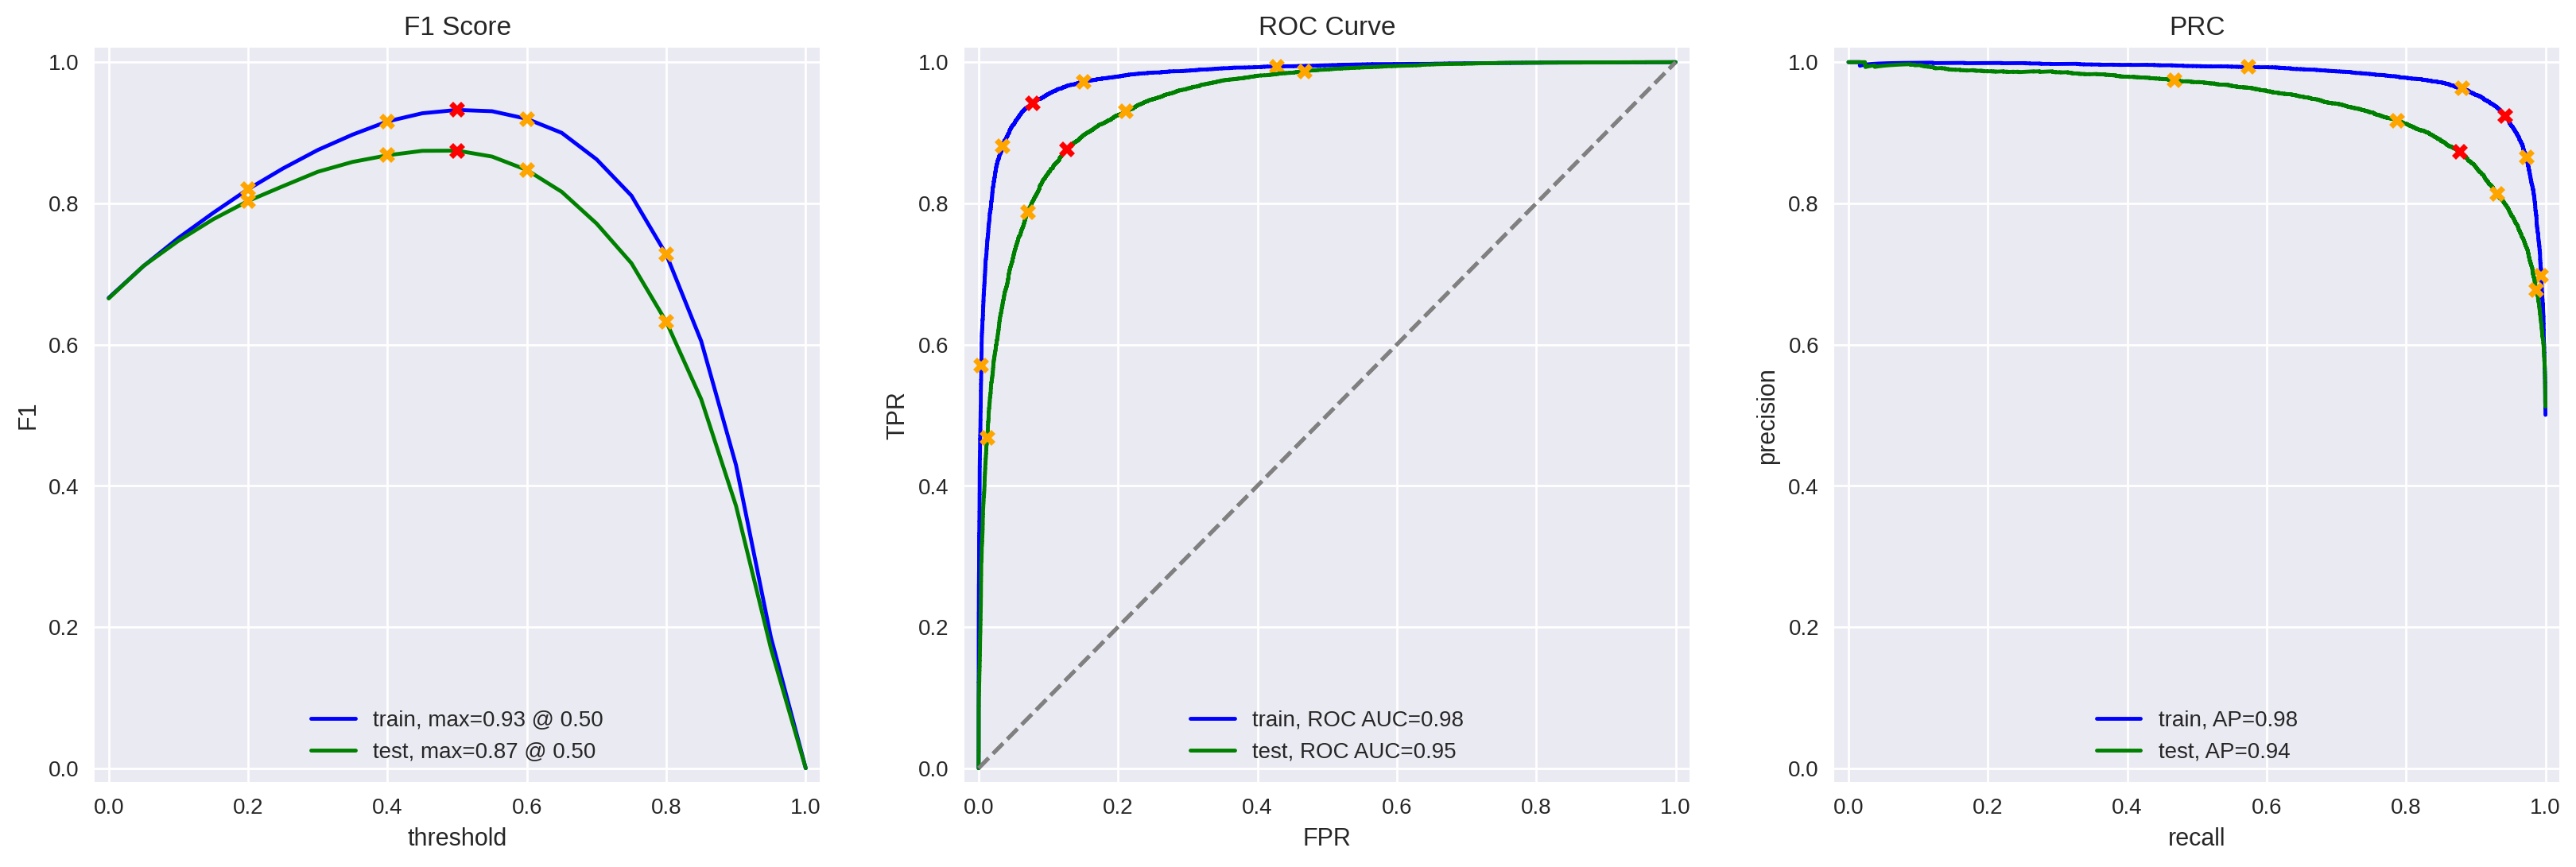

In [37]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Whether using NLTK or spaCy, the Logistic Regression model performs fairly similar, with NLTK having a slight advantage.  However, an F1 of 0.87 on the test set is still very good.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [38]:
from lightgbm import LGBMClassifier
import time

In [39]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [53]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 0.1,
    'random_state': 21,
    'verbose': -1
}

num_boost_round = 30

model_3 = LGBMClassifier(**params, n_estimators=num_boost_round)

start_time_lgb = time.time()
model_3.fit(train_features_2, train_target)
end_time_lgb = time.time()

print(f"Training time: {end_time_lgb - start_time_lgb: .3f}")

Training time:  13.412


          train  test
Accuracy   0.80  0.79
F1         0.81  0.80
APS        0.88  0.87
ROC AUC    0.89  0.87


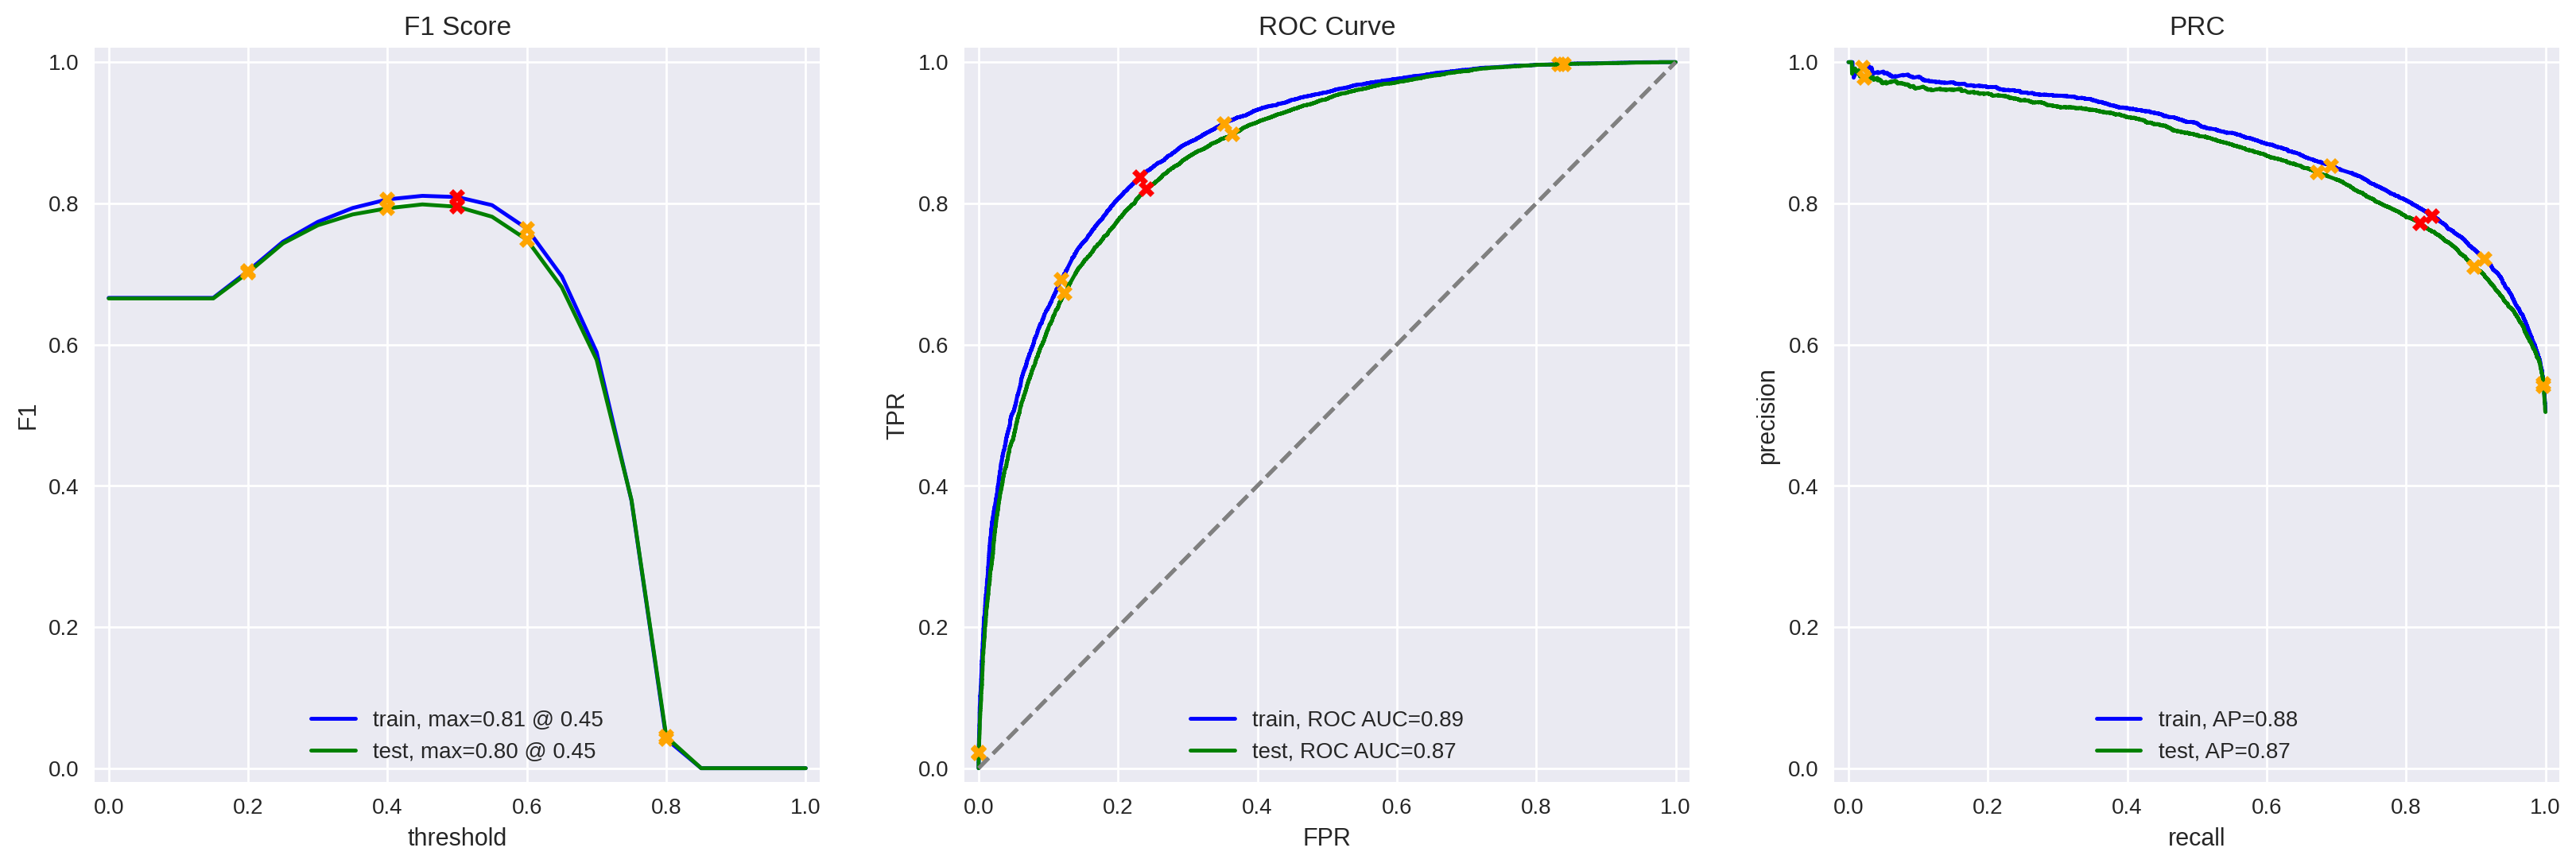

In [54]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

LGBMClassifier performs ok, but nowhere near as well as Linear Regression in terms of F1 score.  On a positive note, it generalizes well, with accuracy of 0.81 on the train set and 0.8 on the test set.

###  Model 4 - BERT

In [55]:
import torch
import transformers

In [56]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
import torch
import numpy as np
import math
import gc
from tqdm import tqdm

def BERT_text_to_embeddings_chunked(texts, tokenizer, model, 
                                     max_length=128, batch_size=4, 
                                     force_device=None, disable_progress_bar=False):
    
    device = torch.device(force_device) if force_device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    if not disable_progress_bar:
        print(f'Using device: {device}')
    
    all_embeddings = []

    for start_idx in range(0, len(texts), 1000):  # Chunk of 1000 texts
        chunk = texts[start_idx:start_idx+1000]
        ids_list, attention_mask_list = [], []

        for text in chunk:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True
            )
            ids_list.append(encoded['input_ids'])
            attention_mask_list.append(encoded['attention_mask'])

        embeddings = []

        for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            batch_ids = torch.LongTensor(ids_list[i*batch_size:(i+1)*batch_size]).to(device)
            batch_mask = torch.LongTensor(attention_mask_list[i*batch_size:(i+1)*batch_size]).to(device)

            with torch.no_grad():
                output = model(input_ids=batch_ids, attention_mask=batch_mask)
                cls_embeddings = output.last_hidden_state[:, 0, :]
                embeddings.append(cls_embeddings.cpu().numpy())

            del batch_ids, batch_mask, output, cls_embeddings
            torch.cuda.empty_cache()
            gc.collect()

        all_embeddings.append(np.concatenate(embeddings))

        # Also free memory from this chunk
        del ids_list, attention_mask_list, embeddings
        gc.collect()

    return np.concatenate(all_embeddings)


In [58]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# add force_device = "cuda"
train_features_4 = BERT_text_to_embeddings_chunked(df_reviews_train['review_norm'], tokenizer, model)

Using device: cpu


  2%|▏         | 4/250 [00:24<25:20,  6.18s/it]


KeyboardInterrupt: 

In [23]:
print(df_reviews_train['review_norm'].shape)
print(train_features_4.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [ ]:
test_features_4 = BERT_text_to_embeddings_chunked(df_reviews_test['review_norm'], tokenizer, model)

In [28]:
print(df_reviews_test['review_norm'].shape)
print(test_features_4.shape)
print(test_target.shape)

(23535,)
(23535, 768)
(23535,)


In [ ]:
np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)

with np.load('features_4.npz') as data:
     train_features_4 = data['train_features_4']
     test_features_4 = data['test_features_4']

In [ ]:
model_4 = LogisticRegression(max_iter=1000)
model_4.fit(train_features_4, train_target)
y_pred = model_4.predict(test_features_4)

          train  test
Accuracy   0.82  0.81
F1         0.82  0.81
APS        0.90  0.89
ROC AUC    0.91  0.89


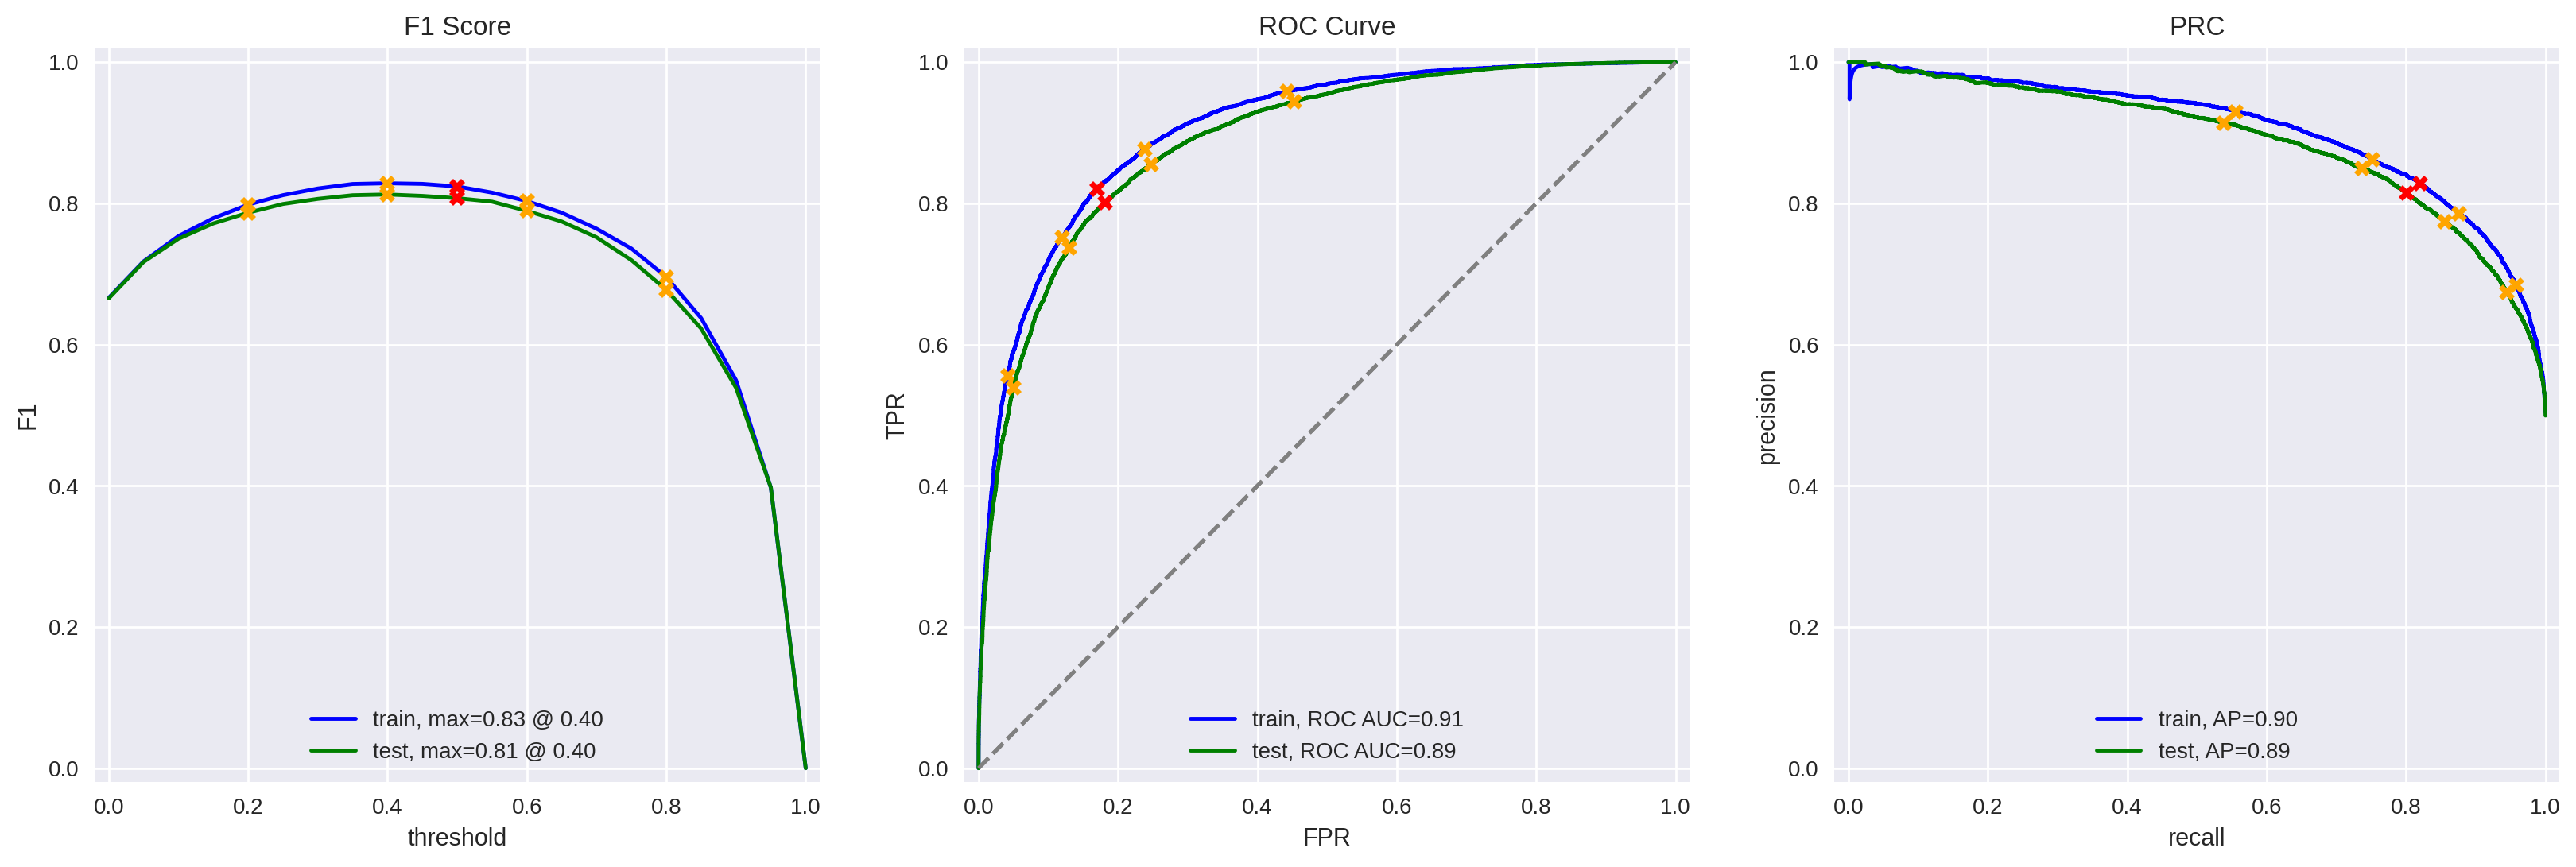

In [35]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

While the BERT embeddings do not perform as well in terms of F1, the model has some strengths.  The model is not overfitting and has a good balance between precision and recall given the F1 score.  The AUC-ROC also demonstrates strong ability to differentiate between classes.

## My Reviews

In [59]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review_norm'])

my_reviews['review_norm'] = my_reviews['review_norm'].astype(str).apply(preprocess_text)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

,review_norm,pos
0,i did not simply like it not my kind of movie,0
1,well i was bored and felt asleep in the middle...,0
2,i was really fascinated with the movie,1
3,even the actors looked really old and disinter...,0
4,i didnt expect the reboot to be so good writer...,1
5,the movie had its upsides and downsides but i ...,1
6,what a rotten attempt at a comedy not a single...,0
7,launching on netflix was a brave move i really...,1


### Model 1

In [61]:
texts = my_reviews['review_norm']
pos = my_reviews['pos']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

preds = []
for i, review in enumerate(texts.str.slice(0, 100)):
    prob = my_reviews_pred_prob
    if my_reviews_pred_prob[i] > 0.5:
        preds.append(1)
    else:
        preds.append(0)
    print(f'Prediction: {preds[i]}, Actual: {pos[i]}, Probability: {prob[i]:.2f},  {review}')
print(f'The F1 score for this dataset is:', metrics.f1_score(pos, preds))

Prediction: 0, Actual: 0, Probability: 0.16,  i did not simply like it not my kind of movie
Prediction: 0, Actual: 0, Probability: 0.18,  well i was bored and felt asleep in the middle of the movie
Prediction: 1, Actual: 1, Probability: 0.56,  i was really fascinated with the movie
Prediction: 0, Actual: 0, Probability: 0.13,  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Prediction: 0, Actual: 1, Probability: 0.26,  i didnt expect the reboot to be so good writers really cared about the source material
Prediction: 0, Actual: 1, Probability: 0.48,  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Prediction: 0, Actual: 0, Probability: 0.05,  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Prediction: 1, Actual: 1, Probability: 0.84,  launching on netflix was a brave move i really appreciate being able to binge on episode after ep

Model 1 does not perform especially well with these reviews.  While it correctly predicts 0-3 and 6-7, it mistakenly classifies 4-5 as negative reviews.  It achieves an F1 of 0.67.

### Model 2

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

preds = []
for i, review in enumerate(texts.str.slice(0, 100)):
    prob = my_reviews_pred_prob
    if my_reviews_pred_prob[i] > 0.5:
        preds.append(1)
    else:
        preds.append(0)
    print(f'Prediction: {preds[i]}, Actual: {pos[i]}, Probability: {prob[i]:.2f},  {review}')
print(f'The F1 score for this dataset is:', metrics.f1_score(pos, preds))

Prediction: 0, Actual: 0, Probability: 0.16,  i did not simply like it not my kind of movie
Prediction: 0, Actual: 0, Probability: 0.07,  well i was bored and felt asleep in the middle of the movie
Prediction: 1, Actual: 1, Probability: 0.50,  i was really fascinated with the movie
Prediction: 0, Actual: 0, Probability: 0.14,  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Prediction: 0, Actual: 1, Probability: 0.23,  i didnt expect the reboot to be so good writers really cared about the source material
Prediction: 0, Actual: 1, Probability: 0.38,  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Prediction: 0, Actual: 0, Probability: 0.02,  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Prediction: 1, Actual: 1, Probability: 0.90,  launching on netflix was a brave move i really appreciate being able to binge on episode after ep

Model 2 performs similarly to model 1, misclassifying 4-5.  It does so with greater confidence, at that, though the F1 score remains the same.

### Model 3

In [65]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

preds = []
for i, review in enumerate(texts.str.slice(0, 100)):
    prob = my_reviews_pred_prob
    if my_reviews_pred_prob[i] > 0.5:
        preds.append(1)
    else:
        preds.append(0)
    print(f'Prediction: {preds[i]}, Actual: {pos[i]}, Probability: {prob[i]:.2f},  {review}')
print(f'The F1 score for this dataset is:', metrics.f1_score(pos, preds))

Prediction: 1, Actual: 0, Probability: 0.59,  i did not simply like it not my kind of movie
Prediction: 1, Actual: 0, Probability: 0.57,  well i was bored and felt asleep in the middle of the movie
Prediction: 1, Actual: 1, Probability: 0.59,  i was really fascinated with the movie
Prediction: 1, Actual: 0, Probability: 0.58,  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Prediction: 1, Actual: 1, Probability: 0.67,  i didnt expect the reboot to be so good writers really cared about the source material
Prediction: 1, Actual: 1, Probability: 0.59,  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
Prediction: 1, Actual: 0, Probability: 0.51,  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Prediction: 1, Actual: 1, Probability: 0.61,  launching on netflix was a brave move i really appreciate being able to binge on episode after ep

Model 3 classified all reviews as positive when only 4 are.  Furthermore, its confidence in its predictions is minimal.  Model 3 is not promising, though its F1 is the same as Models 1 and 2.

### Model 4

In [66]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings_chunked(texts, tokenizer, model, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

preds = []
for i, review in enumerate(texts.str.slice(0, 100)):
    prob = my_reviews_pred_prob
    if my_reviews_pred_prob[i] > 0.5:
        preds.append(1)
    else:
        preds.append(0)
    print(f'Prediction: {preds[i]}, Actual: {pos[i]}, Probability: {prob[i]:.2f},  {review}')
print(f'The F1 score for this dataset is:', metrics.f1_score(pos, preds))

NameError: name 'model_4' is not defined

Model 4 misclassified 1 and 5, but classified the rest correctly.  Notably, it had very high confidence in its misclassifications.  However, the F1 is 0.75.

## Conclusions

The goal of this project was to develop a system capable of automatically identifying negative movie reviews for the Film Junky Union, a new community of classic film enthusiasts. Using a large, well-balanced dataset of over 47,000 IMDB reviews, various models were evaluated to determine their effectiveness in classifying sentiment, with a target F1 score of at least 0.85.

Overall, model 4 using BERT performed the most stably and reliably across the test and final review sets.  It achieved an F1 of 0.81 on the test set and an F1 of 0.75 on the final review set and thus shows consistent ability to classify effectively, making it the best candidate for use in a real-world setting.  Model 1 using NLTK, TF-IDF and LR also performed well, though its high F1 on the test set of 0.88 did not hold true when applied to the final review sample where the F1 plummetted to 0.67.  While the final set of reviews was a small sample, this lack of consistency is troublesome as it indicates a lack of ability to generalize effectively.  Model 2 performed comparably, though had a slightly lower F1 on the test set.  Model 3's performance was lackluster at all stages in terms of F1, though it did generalize well.

Model 4's consistency across diverse review samples will be particularly valuable in a community-driven platform where new and varied content is constantly introduced.  This model provides a strong foundation for automatically filtering and categorizing reviews to enhance user experience on the Film Junky Union platform.